In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/BD LANJUT PRAKTIKUM/DATASET/bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CLASSIFICATION**

In [ ]:
data_take = df.limit(5)
transposed_data = data_take.select([col(column).alias(str(column)) for column in data_take.columns]).toPandas().transpose()
print(transposed_data)

                   0          1           2          3         4
age               59         56          41         55        54
job           admin.     admin.  technician   services    admin.
marital      married    married     married    married   married
education  secondary  secondary   secondary  secondary  tertiary
default           no         no          no         no        no
balance         2343         45        1270       2476       184
housing          yes         no         yes        yes        no
loan              no         no          no         no        no
contact      unknown    unknown     unknown    unknown   unknown
day                5          5           5          5         5
month            may        may         may        may       may
duration        1042       1467        1389        579       673
campaign           1          1           1          1         2
pdays             -1         -1          -1         -1        -1
previous           0     

In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [ ]:
grouped_data = df.groupBy('deposit').count()
grouped_data.show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

# yang diambil hanya kolom yang memiliki fitur numerik
numeric_summary = df.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|age               |balance           |day               |duration          |campaign          |pdays             |previous          |
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|count  |11162             |11162             |11162             |11162             |11162             |11162             |11162             |
|mean   |41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043|2.508421429851281 |51.33040673714388 |0.8325568894463358|
|stddev |11.913369192215518|3225.413325946149 |8.420739541006462 |347.12838571630687|2.7220771816614824|108.75828197197717|2.292007218670508 |
|min    |18                |-6847             |1                 |2                 |1                 |-1                |0                 |

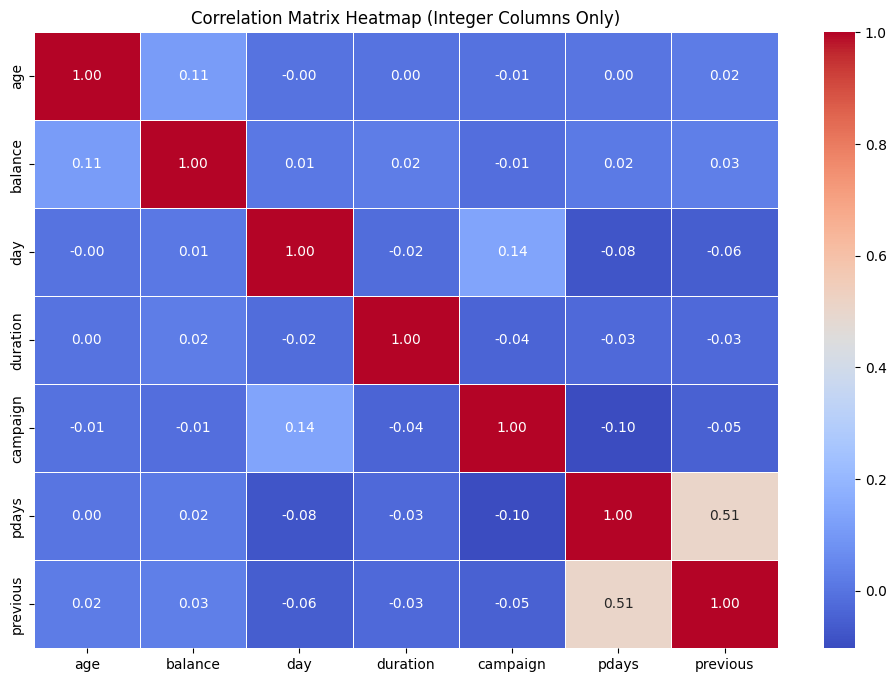

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Memilih kolom-kolom dengan tipe data integer
integer_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'int']

# Menentukan kolom-kolom yang akan digunakan
vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
df_assembled = vector_assembler.transform(df).select("features")

# Menghitung matriks korelasi
matrix = Correlation.corr(df_assembled, "features").head()
correlation_matrix = matrix[0].toArray()

# Mendapatkan nama kolom dari DataFrame yang dihasilkan setelah transformasi
column_names = df_assembled.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

# Membuat heatmap dengan nama kolom pada sumbu x dan y
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5,
            xticklabels=[col["name"] for col in column_names], yticklabels=[col["name"] for col in column_names])
plt.title("Correlation Matrix Heatmap (Integer Columns Only)")
plt.show()

In [ ]:
# Drop kolom 'day' dan 'month' dan simpan hasilnya di variabel yang sama
df = df.drop('day', 'month')

# Periksa skema DataFrame yang baru
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



# **PREPARE DATA MACHINE LEARNING**

Category Indexing, One-Hot Encoding and VectorAssembler - a feature transformer that merges multiple columns into a vector column.



In [ ]:
# Import modul-modul yang dibutuhkan dari Spark ML
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Daftar kolom-kolom kategori yang perlu diindeks dan dienkripsi
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Inisialisasi list stages untuk menyimpan tahap-tahap transformasi
stages = []

# Loop untuk setiap kolom kategori
for categoricalCol in categoricalColumns:
    # StringIndexer mengonversi nilai kategori menjadi label numerik
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')

    # OneHotEncoder mengonversi label numerik menjadi vektor biner (one-hot encoding)
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    # Menambahkan tahapan StringIndexer dan OneHotEncoder ke dalam list stages
    stages += [stringIndexer, encoder]

# StringIndexer untuk kolom target ('deposit'), mengonversi nilai target menjadi label numerik
label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_stringIdx]

# Kolom-kolom numerik yang tidak perlu diindeks atau dienkripsi
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Menentukan kolom-kolom input untuk VectorAssembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# VectorAssembler menggabungkan kolom-kolom input menjadi satu kolom vektor fitur ('features')
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Menambahkan tahap VectorAssembler ke dalam list stages
stages += [assembler]


# **PIPELINE**

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + df.columns
df_transformed = df_transformed.select(selectedCols)
df = df_transformed
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


# **Factorization machines classifier**

In [ ]:
from pyspark.ml.classification import FMClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Ganti LinearSVC dengan FMClassifier
fm = FMClassifier(featuresCol='features', labelCol='label', maxIter=5)
fmModel = fm.fit(train)
predictions = fmModel.transform(test)

# Menampilkan beberapa kolom yang dipilih
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction').show(10)


+---+----------+-----+--------------------+----------+
|age|       job|label|       rawPrediction|prediction|
+---+----------+-----+--------------------+----------+
| 33|management|  0.0|[1499.72504911401...|       0.0|
| 49|management|  0.0|[19214.8102115048...|       0.0|
| 52|management|  0.0|[-522461.25995689...|       1.0|
| 53|management|  0.0|[-33562.307167894...|       1.0|
| 58|management|  0.0|[3401.37835847955...|       0.0|
| 32|management|  0.0|[4964.85971996433...|       0.0|
| 57|management|  0.0|[5507.72722495101...|       0.0|
| 52|management|  0.0|[3337.40853654874...|       0.0|
| 46|management|  0.0|[5756.36681361956...|       0.0|
| 31|management|  0.0|[1291.88007763457...|       0.0|
+---+----------+-----+--------------------+----------+
only showing top 10 rows



In [ ]:
# from pyspark.ml.classification import LinearSVC
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# lsvc = LinearSVC(featuresCol='features', labelCol='label', maxIter=1)
# lsvcModel = lsvc.fit(train)
# predictions = lsvcModel.transform(test)
# predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction').show(10)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7230727889901268


In [ ]:
evaluator.getMetricName()

'areaUnderROC'

In [ ]:
print(fm.explainParams())

factorSize: Dimensionality of the factor vectors, which are used to get pairwise interactions between variables (default: 8)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
fitLinear: whether to fit linear term (aka 1-way term) (default: True)
initStd: standard deviation of initial coefficients (default: 0.01)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100, current: 5)
miniBatchFraction: fraction of the input data set that should be used for one iteration of gradient descent (default: 1.0)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Parameter grid untuk FMClassifier
paramGrid = (ParamGridBuilder()
             .addGrid(fm.maxIter, [20, 30, 40])
             .addGrid(fm.regParam, [0.1, 0.01, 0.001])
             .addGrid(fm.stepSize, [0.1, 0.01, 0.001])
             .addGrid(fm.tol, [1e-4, 1e-5])
             .build())
# Inisialisasi BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

# Inisialisasi CrossValidator
cv = CrossValidator(estimator=fm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

# Run cross validations
cvModel = cv.fit(train)

# Memprediksi pada data uji
predictions = cvModel.transform(test)

# Menghitung AUC-ROC
auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("AUC-ROC: ", auc_roc)

AUC-ROC:  0.8044837438019672


Tuning dalam konteks machine learning (ML) merujuk pada proses penyesuaian parameter atau konfigurasi model untuk mencapai kinerja yang lebih baik. Tujuan utamanya adalah meningkatkan performa model pada tugas tertentu. Setelah dilakukan Tuning AUC-ROC dapat meningkat tetapi tidak significan. Dengan sebelum dilakukan 0.7230727889901268 dan setelah dilakukan tuning 0.8044837438019672.